In [225]:
%matplotlib inline
import pandas as pd
import numpy as np
import multiprocessing
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist
from collections import Counter
import random
import re
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.models.word2vec as w2v
import sklearn.manifold
import time
sns.set_style("darkgrid")

In [236]:
df = pd.read_csv('fake.csv', usecols = ['uuid','author','title','text','language','site_url','country'])
df = df[df.language == 'english']
df['title'].fillna(value="", inplace=True)
df.dropna(axis=0, inplace=True, subset=['text'])
df = df.sample(frac=1.0)
df.reset_index(drop=True,inplace=True)
df.head(10)

,uuid,author,title,text,language,site_url,country
0,0e611ace89a6a50b07cd587778dde1855601e8f0,J.E. Dyer,Germany: Children in one school required to ch...,"Print \n[Ed. – Coming soon to a — oh, wait. It...",english,libertyunyielding.com,US
1,58016c4fc9091b1b0b6711620f775c95e9d834a7,BareNakedIslam,"MILO at Dartmouth College on Donald Trump, rea...",Notify me of follow-up comments by email. Noti...,english,barenakedislam.com,US
2,d6f4f47c9d3c7027a5be8ab54c202dbe6e89204b,NaN,"Julian Assange Isn’t Done With Hillary, Reveal...",\nI have been reporting for weeks now about th...,english,endingthefed.com,US
3,6c7c3b19f1fbadd026f6b18f7adb5fea7346e9b9,John Patriot,Re: Apostate Evangelicals Are Poised To Become...,"Print \nIf you look at the numbers, there is n...",english,freedomoutpost.com,US
4,d845bd12e98e968eab24ad0709ffa4714e0fd722,Daisy Luther,AG Lynch Told FBI Director Comey NOT To Go Pub...,"in: Government , Government Corruption , Sleut...",english,thesleuthjournal.com,US
5,5f3bc4d12d0b7c521d79d80120d7b2c7965655b8,NaN,"Racists, Misogynists and Homophobes all absolu...",Wednesday 9 November 2016 by Lucas Wilde Racis...,english,newsthump.com,US
6,1b1dae3da4bcbdc57afad22e20d8bed710778b68,Alex Ansary,Russia Unveils Update of Advanced Nuclear Weapon,Russia Unveils Update of Advanced Nuclear Weap...,english,amtvmedia.com,US
7,b5fd0cb3f5c6583a9ab419f8b5d39f9e04ba4055,admin,Dying out: Wild animal numbers could fall by 6...,"RT October 27, 2016 \nThe number of wild anima...",english,prisonplanet.com,US
8,8c66a0c14681e6a1b1df05febee0df40e0b656f5,MeThePeople,Comment on Trump’s Walk of Fame Star Vandalize...,"Posted on October 27, 2016 by DCG | 14 Comment...",english,fellowshipoftheminds.com,US
9,14c98af2e0cd4e468b1697acb27a6e78d5c9c5a4,The Doc,Regret Ever Buying Gold and Silver? AGXIIK Has...,Tweet Home » Gold » Gold News » Regret Ever Bu...,english,silverdoctors.com,US


### comment on tokenizing by sentence, removing websites etc.

In [237]:
def sent_tokenizer(text):
    text = nltk.sent_tokenize(text)
    return text

def normalize(text):
    new_text = []
    for sentence in text:
        normed = nltk.word_tokenize(sentence.lower())
        new_text.append(normed)
    return new_text

def sentence_cleaner(text):
    new_text = []
    for sentence in text:
        sentence = ' '.join(sentence)
        sentence = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", sentence)
        sentence = re.sub("[^a-zA-Z ]", "", sentence)
        sentence = nltk.word_tokenize(sentence)
        new_text.append(sentence)
    return new_text

def apply_all(text):
    return sentence_cleaner(normalize(sent_tokenizer(text)))

In [238]:
df['sent_tokenized_text'] = df['text'].apply(apply_all)
df.head(10)

,uuid,author,title,text,language,site_url,country,sent_tokenized_text
0,0e611ace89a6a50b07cd587778dde1855601e8f0,J.E. Dyer,Germany: Children in one school required to ch...,"Print \n[Ed. – Coming soon to a — oh, wait. It...",english,libertyunyielding.com,US,"[[print, ed], [coming, soon, to, a, oh, wait],..."
1,58016c4fc9091b1b0b6711620f775c95e9d834a7,BareNakedIslam,"MILO at Dartmouth College on Donald Trump, rea...",Notify me of follow-up comments by email. Noti...,english,barenakedislam.com,US,"[[notify, me, of, followup, comments, by, emai..."
2,d6f4f47c9d3c7027a5be8ab54c202dbe6e89204b,NaN,"Julian Assange Isn’t Done With Hillary, Reveal...",\nI have been reporting for weeks now about th...,english,endingthefed.com,US,"[[i, have, been, reporting, for, weeks, now, a..."
3,6c7c3b19f1fbadd026f6b18f7adb5fea7346e9b9,John Patriot,Re: Apostate Evangelicals Are Poised To Become...,"Print \nIf you look at the numbers, there is n...",english,freedomoutpost.com,US,"[[print, if, you, look, at, the, numbers, ther..."
4,d845bd12e98e968eab24ad0709ffa4714e0fd722,Daisy Luther,AG Lynch Told FBI Director Comey NOT To Go Pub...,"in: Government , Government Corruption , Sleut...",english,thesleuthjournal.com,US,"[[in, government, government, corruption, sleu..."
5,5f3bc4d12d0b7c521d79d80120d7b2c7965655b8,NaN,"Racists, Misogynists and Homophobes all absolu...",Wednesday 9 November 2016 by Lucas Wilde Racis...,english,newsthump.com,US,"[[wednesday, november, by, lucas, wilde, racis..."
6,1b1dae3da4bcbdc57afad22e20d8bed710778b68,Alex Ansary,Russia Unveils Update of Advanced Nuclear Weapon,Russia Unveils Update of Advanced Nuclear Weap...,english,amtvmedia.com,US,"[[russia, unveils, update, of, advanced, nucle..."
7,b5fd0cb3f5c6583a9ab419f8b5d39f9e04ba4055,admin,Dying out: Wild animal numbers could fall by 6...,"RT October 27, 2016 \nThe number of wild anima...",english,prisonplanet.com,US,"[[rt, october, the, number, of, wild, animals,..."
8,8c66a0c14681e6a1b1df05febee0df40e0b656f5,MeThePeople,Comment on Trump’s Walk of Fame Star Vandalize...,"Posted on October 27, 2016 by DCG | 14 Comment...",english,fellowshipoftheminds.com,US,"[[posted, on, october, by, dcg, comments, libe..."
9,14c98af2e0cd4e468b1697acb27a6e78d5c9c5a4,The Doc,Regret Ever Buying Gold and Silver? AGXIIK Has...,Tweet Home » Gold » Gold News » Regret Ever Bu...,english,silverdoctors.com,US,"[[tweet, home, gold, gold, news, regret, ever,..."


In [239]:
all_words = list(df['sent_tokenized_text'])
all_words = [word for item in all_words for word in item]
all_words = [subitem for item in all_words for subitem in item]

In [240]:
fdist = FreqDist(all_words)
len(fdist)

112878

In [241]:
fdist.most_common(20)

[('the', 474603),
 ('to', 223626),
 ('of', 223434),
 ('and', 205588),
 ('a', 159535),
 ('in', 149306),
 ('that', 109062),
 ('is', 101280),
 ('for', 72189),
 ('on', 59743),
 ('it', 57726),
 ('as', 53222),
 ('with', 50903),
 ('are', 48321),
 ('this', 47946),
 ('by', 44807),
 ('be', 43041),
 ('was', 41835),
 ('have', 39840),
 ('not', 38532)]

In [242]:
k = 30000
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)

In [243]:
def doc_length(text):
    return len([word for sent in text for word in sent])

In [244]:
# document length
df['doc_len'] = df['sent_tokenized_text'].apply(doc_length)
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

In [245]:
print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

length of list: 12357 
average document length 634.822044185 
maximum document length 23885


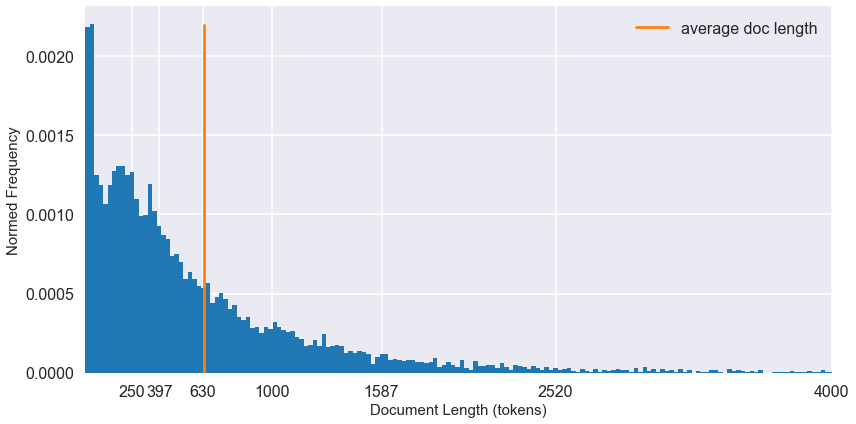

In [246]:
# plot a histogram of document length

num_bins = 1000
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins, normed=1)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
# ax.set_title(r'Frequency of eucildean distance between point pairs', fontsize=20)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(250),stop=np.log10(4000),num=7, base=10.0))
plt.xlim(0,4000)

ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0022,100)], np.linspace(0.0,0.0022,100), '-',
        label='average doc length')

ax.legend()
ax.grid()

fig.tight_layout()
plt.show()

In [247]:
def include_top_k_words(text):
    new_text = []
    for sent in text:
        temp = [word for word in sent if word in top_k_words if len(word)>1]
        new_text.append(temp)
    return new_text

In [248]:
df['sent_tokenized_text'] = df['sent_tokenized_text'].apply(include_top_k_words)
df.head(10)

,uuid,author,title,text,language,site_url,country,sent_tokenized_text
0,0e611ace89a6a50b07cd587778dde1855601e8f0,J.E. Dyer,Germany: Children in one school required to ch...,"Print \n[Ed. – Coming soon to a — oh, wait. It...",english,libertyunyielding.com,US,"[[print, ed], [coming, soon, to, oh, wait], [i..."
1,58016c4fc9091b1b0b6711620f775c95e9d834a7,BareNakedIslam,"MILO at Dartmouth College on Donald Trump, rea...",Notify me of follow-up comments by email. Noti...,english,barenakedislam.com,US,"[[notify, me, of, followup, comments, by, emai..."
2,d6f4f47c9d3c7027a5be8ab54c202dbe6e89204b,NaN,"Julian Assange Isn’t Done With Hillary, Reveal...",\nI have been reporting for weeks now about th...,english,endingthefed.com,US,"[[have, been, reporting, for, weeks, now, abou..."
3,6c7c3b19f1fbadd026f6b18f7adb5fea7346e9b9,John Patriot,Re: Apostate Evangelicals Are Poised To Become...,"Print \nIf you look at the numbers, there is n...",english,freedomoutpost.com,US,"[[print, if, you, look, at, the, numbers, ther..."
4,d845bd12e98e968eab24ad0709ffa4714e0fd722,Daisy Luther,AG Lynch Told FBI Director Comey NOT To Go Pub...,"in: Government , Government Corruption , Sleut...",english,thesleuthjournal.com,US,"[[in, government, government, corruption, sleu..."
5,5f3bc4d12d0b7c521d79d80120d7b2c7965655b8,NaN,"Racists, Misogynists and Homophobes all absolu...",Wednesday 9 November 2016 by Lucas Wilde Racis...,english,newsthump.com,US,"[[wednesday, november, by, lucas, wilde, racis..."
6,1b1dae3da4bcbdc57afad22e20d8bed710778b68,Alex Ansary,Russia Unveils Update of Advanced Nuclear Weapon,Russia Unveils Update of Advanced Nuclear Weap...,english,amtvmedia.com,US,"[[russia, unveils, update, of, advanced, nucle..."
7,b5fd0cb3f5c6583a9ab419f8b5d39f9e04ba4055,admin,Dying out: Wild animal numbers could fall by 6...,"RT October 27, 2016 \nThe number of wild anima...",english,prisonplanet.com,US,"[[rt, october, the, number, of, wild, animals,..."
8,8c66a0c14681e6a1b1df05febee0df40e0b656f5,MeThePeople,Comment on Trump’s Walk of Fame Star Vandalize...,"Posted on October 27, 2016 by DCG | 14 Comment...",english,fellowshipoftheminds.com,US,"[[posted, on, october, by, dcg, comments, libe..."
9,14c98af2e0cd4e468b1697acb27a6e78d5c9c5a4,The Doc,Regret Ever Buying Gold and Silver? AGXIIK Has...,Tweet Home » Gold » Gold News » Regret Ever Bu...,english,silverdoctors.com,US,"[[tweet, home, gold, gold, news, regret, ever,..."


In [249]:
all_sentences = list(df['sent_tokenized_text'])

In [250]:
all_sentences = [subitem for item in all_sentences for subitem in item]

In [251]:
all_sentences[0:3]

[['print', 'ed'],
 ['coming', 'soon', 'to', 'oh', 'wait'],
 ['its', 'already', 'here']]

In [136]:
token_count = sum([len(sentence) for sentence in all_sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 7,462,889 tokens


## Word2vec

At a high level, word2vec turns all words from a corpus into vectors in some medium dimensional (100-300) vector space. This vector space can be thought of as a "semmantic" or "contextual" vector space. In this vector space, words that are close to each other, in a euclidean distance sense, are semmantically simmilar. For example, the words "car" and "engine" would be semmantically close to each other, or the words "machine" and "learnig" would also be semmantically close to each other. The word2vec does this in a completely unsupervised way, simply by calculating distributions for words and a surrounding window of context words.

This representation of words, more formally known as word embeddings, is extremely useful for understanding language and sentiment in a corpus.

Word vectors are constructed in the following way.

Word2vec is based on a 2 layer neural network.
In the first layer, OHE word vectors are multiplied by an input weight matrix $WI$. The output is then passed through an activation function, in this case a sigmoid $\sigma$, to convert the output vectors to probabilities.
In the second layer, the output of the first layer is again multiplied by an output weight matrix $WO$, and these vector outputs are passed through another sigmoid to be converted to probabilities. This final output are the word vectors.

At first the weight matrices are randomly assigned, so the first iteration will produce poor word vectors; poor in the sense that similar words wont necessarily be close to each other. However, by minimising the error, and updating the weight matrices to correct for this, the word vectors become better and better. This process is known as backpropagation through gradient descent.

The mathematics takes the form below.

The input word vector $X$ multiplied by the weight matrix $WI$
$$u=X^TWI \hspace{10mm}$$

$u$ is the passed through a sigmoid
$$h = \sigma (u) = \frac{1}{1+e^{-u}}$$

Then $h$ is multipled by the output weight matrix $WO$
$$u' = h^TWO$$

The output of which is passed through the final sigmoid

$$y = \sigma(u') = \frac{1}{1+e^{-u'}}$$

The probability of seeing a word given the context words in word2vec, are calculated using the softmax function. The error to be minimised is the negative log likelihood of this probability.

$$\text{softmax} = p(w_k|w_{\text{context}}) = \frac{\exp(u^T \cdot v)}{\sum_{k=1}^V \exp(u^Tv_k)}$$

Log likelihood to be minimized:

$$-\log(p(w_k|w_{\text{context}})) = -\log\left( \frac{\exp(u^T \cdot v)}{\sum_{k=1}^V \exp(u^Tv_k)} \right)$$

We set the partial derivative of the above to zero to update weights of the weight matrices.

Some last and very quick comments on word2vec hyperparamaters:

- num_features is the number of dimensions we want to embed our words in (the length of the final word vectors)
- min_word_count, if the count of a words use is below this threshold, corpus wide, ignore the word
- context_size is the window size left and right of the target word to consider words

In [252]:
num_features = 300 # number of dimensions
min_word_count = 15 # if any words appear less than this amount of times, disregard it
num_workers = multiprocessing.cpu_count()
context_size = 7 # window size around target word to analyse
downsampling = 1e-3 # downsample frequent words
seed = 1 # seed for RNG

In [253]:
fake2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [254]:
fake2vec.build_vocab(all_sentences)

In [255]:
print("Word2Vec vocabulary length:", len(fake2vec.wv.vocab))

Word2Vec vocabulary length: 20633


In [256]:
# number of sentences
fake2vec.corpus_count

348219

In [257]:
# train word2vec
fake2vec.train(all_sentences, total_examples=fake2vec.corpus_count, epochs=fake2vec.iter)

29026404

In [258]:
# dense 2D matrix of word vectors
all_word_vectors_matrix = fake2vec.wv.syn0

In [259]:
all_word_vectors_matrix.shape

(20633, 300)

In [260]:
# train tsne model for visualisation
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
t1 = time.time()
all_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)
t2 = time.time()
print("time to train TSNE on", all_word_vectors_matrix.shape[0], "word vectors:", (t2-t1)/60, "min")

time to train TSNE on 20633 word vectors: 13.391955188910167 min


In [261]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix_2d[fake2vec.wv.vocab[word].index])
            for word in fake2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

In [265]:
def plot_region(x_bounds, y_bounds):
    slice = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

In [262]:
points.head(10)

,word,x,y
0,print,19.276423,1.194554
1,ed,31.267769,27.440218
2,coming,2.049094,-18.099503
3,soon,-2.361925,-12.554673
4,to,-14.338049,-7.198379
5,oh,-0.125090,-5.518572
6,wait,2.308414,-9.917480
7,its,-12.626350,3.264481
8,already,-9.781607,14.111980
9,here,14.578177,4.808187


In [263]:
sns.set_context("poster")

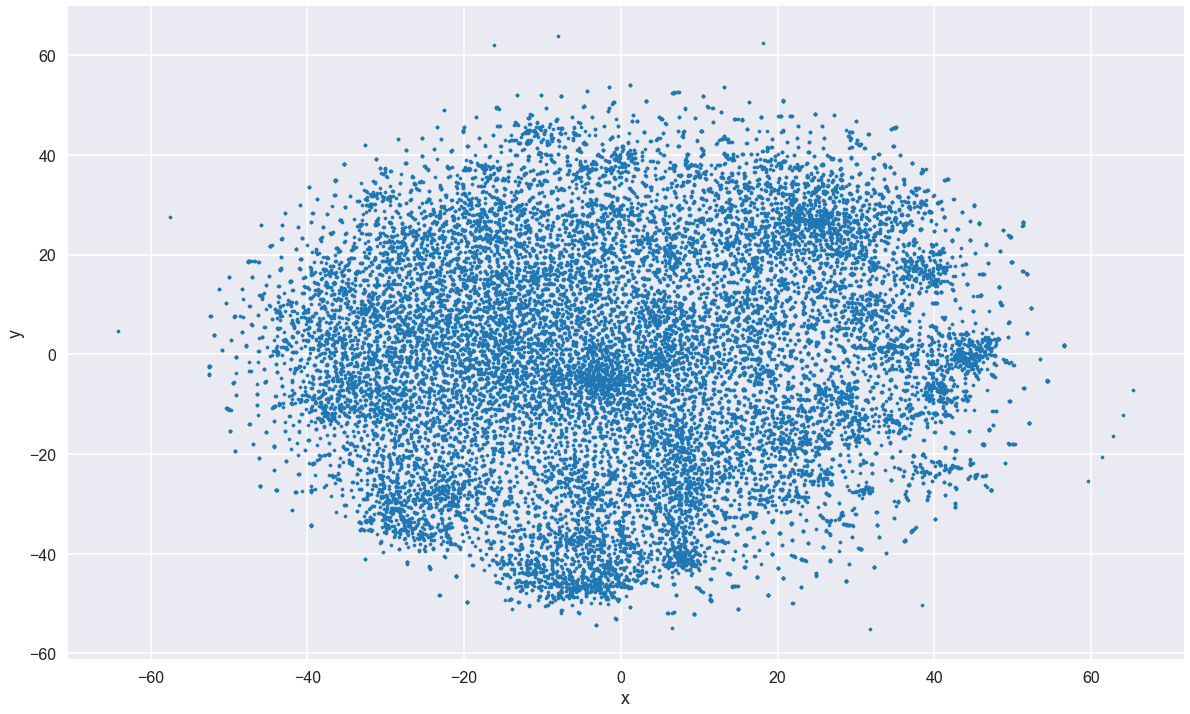

In [264]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

The points above may look like random unorganised noise, but if we zoom into any dense region we see that all words nearby are related.

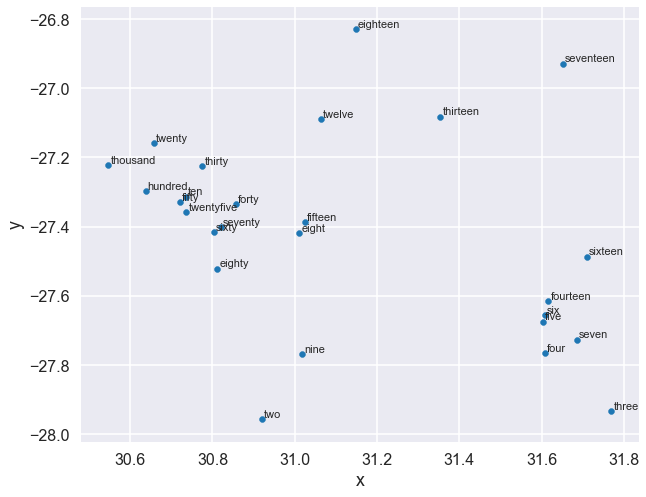

In [269]:
# numbers
plot_region((30.5,32), (-28,-26.75))

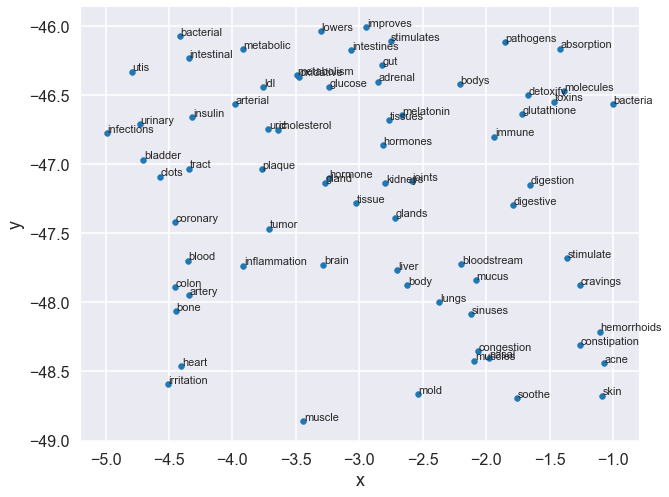

In [274]:
# medical issues / anatomy
plot_region((-5,-1), (-49,-46))

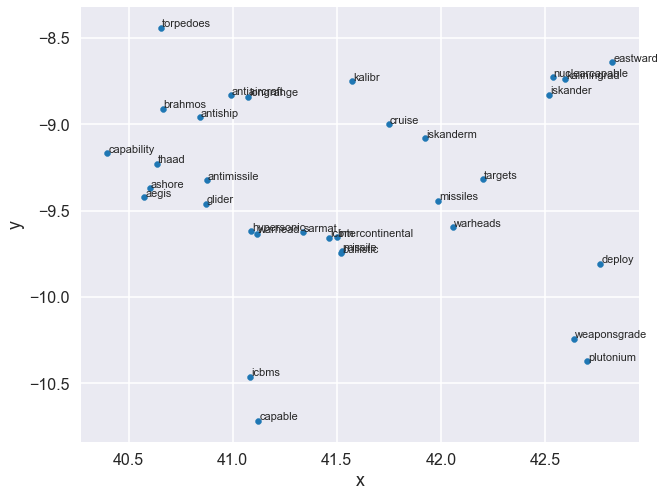

In [278]:
# military equipment
plot_region((40,43), (-11,-8))

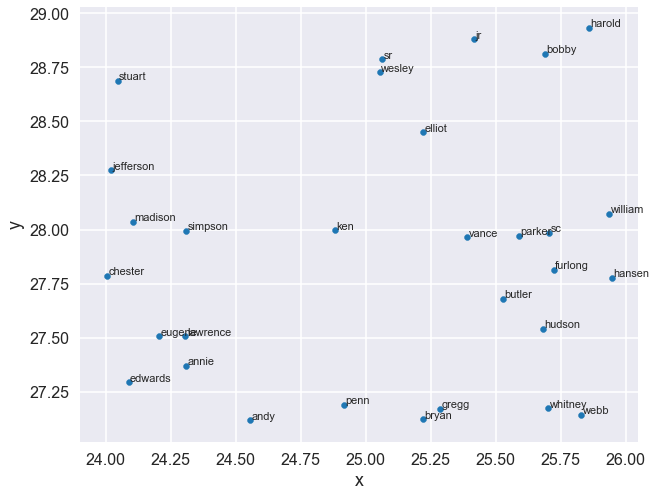

In [280]:
# names
plot_region((24,26), (27,29))

#### CAUTION: Biases ahead

In [285]:
# similar word relations
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = fake2vec.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [176]:
fake2vec.most_similar('muslim')

[('brotherhood', 0.6151938438415527),
 ('freeloaders', 0.5662642121315002),
 ('somali', 0.5575268864631653),
 ('nonmuslim', 0.5547499656677246),
 ('invader', 0.5338033437728882),
 ('muslims', 0.5223865509033203),
 ('brotherhoods', 0.5216660499572754),
 ('holiest', 0.5069468021392822),
 ('nonmuslims', 0.5060951113700867),
 ('haram', 0.5052671432495117)]

In [177]:
fake2vec.most_similar('trump')

[('donald', 0.721954882144928),
 ('trumps', 0.6496169567108154),
 ('presumptive', 0.5685884952545166),
 ('yuge', 0.552943766117096),
 ('temperamentally', 0.5363315343856812),
 ('vitriol', 0.5353009104728699),
 ('donalds', 0.5340932607650757),
 ('presidentelect', 0.5289227962493896),
 ('reassuring', 0.5209646821022034),
 ('temperamental', 0.5147078037261963)]

In [198]:
fake2vec.most_similar('clinton')

[('clintons', 0.6707354187965393),
 ('hillary', 0.6540498733520508),
 ('rodham', 0.5577473640441895),
 ('hilary', 0.5527166128158569),
 ('robbie', 0.5321581363677979),
 ('killery', 0.5303435921669006),
 ('blumenthals', 0.5288667678833008),
 ('crooked', 0.5238121747970581),
 ('dogged', 0.5228588581085205),
 ('scandalridden', 0.5228548645973206)]

In [287]:
nearest_similarity_cosmul("trump", "presidentelect", "clinton")

trump is related to presidentelect, as hillary is related to clinton


'hillary'